<a href="https://colab.research.google.com/github/cxl214a/LAOSIJIFACHELE-/blob/master/project_starter_code_v3.2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Updates Nov 10th, 2018**
* OpenSlide can now be installed in Colab.
* A folder containing example slides and tumor masks is linked below. These should be sufficient for your project. The goal is to build a working end-to-end prototype, not to match the accuracy from the papers (or to train on a giant amount of data).


---


Below is an example program that shows how to read slides and tumor masks from the [CAMELYON16](https://camelyon17.grand-challenge.org/Data/) dataset. 

* To run this code, first you will need to install [OpenSlide](https://openslide.org/), the only non-Python dependency. 

* You can find a folder of slides and tumor masks [here](https://drive.google.com/drive/folders/1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5?usp=sharing). There are 22 slides and tissue masks. The tissue masks were produced using [ASAP](https://github.com/computationalpathologygroup/ASAP) and the instructions on the competition website. I did this in advance for you, so you wouldn't have to spend energy installing ASAP (it has a variety of dependencies, depending on your OS). This way, you'll only need to install OpenSlide.

* This amount of data should be more than sufficient for our project. (If you'd like to work with more, you will need to produce tissue masks yourself using ASAP). 


* OpenSlide also includes a [DeepZoom viewer](https://github.com/openslide/openslide-python/tree/master/examples/deepzoom) you can use to view the tissue images (after installing open slide, clone that repo, `cd` into the examples, and run `python deepzoom_server.py`. You will need install open slide on your computer, and run this notebook locally for that to work.







In [12]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import random

In [0]:
# Download an example slide and tumor mask
# Note: these are hosted on Google Cloud Storage.
# The remainder are in a Google Drive folder, linked above.

slide_path = 'tumor_091.tif'
tumor_mask_path = 'tumor_091_mask.tif'

slide_url = 'https://storage.googleapis.com/applied-dl/%s' % slide_path
mask_url = 'https://storage.googleapis.com/applied-dl/%s' % tumor_mask_path


# Download the whole slide image
if not os.path.exists(slide_path):
  !curl -O $slide_url

# Download the tumor mask
if not os.path.exists(tumor_mask_path):
  !curl -O $mask_url

In [15]:
slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read WSI from tumor_091.tif with width: 61440, height: 53760
Read tumor mask from tumor_091_mask.tif
('Slide includes %d levels', 8)
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64
Level 7, dimensions: (480, 420) downsample factor 128


In [0]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

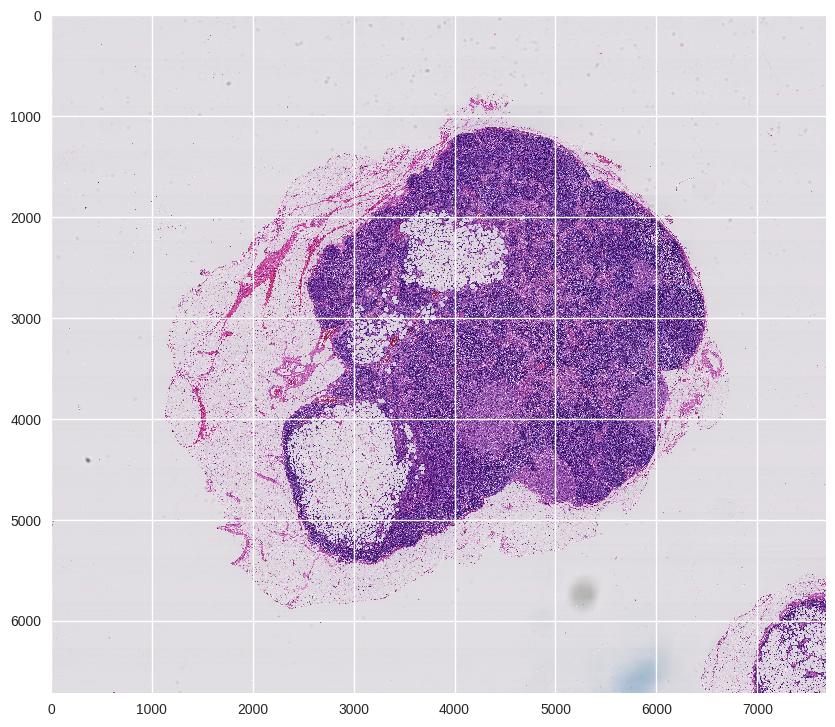

In [17]:
# Example: read the entire slide at level 5

# High zoom levels may not fit into memory.
# That's why we use OpenSlide. You can use the below function
# to extract regions from high zoom levels without having to 
# read the entire image.

# Note: this is just for demo purposes. 

# Use the sliding window approach discussed in class to collect training
# data for your classifier. E.g., slide a window across the slide (for
# starters, use a zoomed out view, so you're not working with giant images).
# Save each window to disk as an image. To find the label for that image, 
# check to see if same region on the mask image contains cancerous cells.

# Important: this is tricky to get right. Carefully debug your pipeline before
# training your model. Start with just a single image, and a relatively 
# low zoom level.

slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=3, 
                         width=slide.level_dimensions[3][0], 
                         height=slide.level_dimensions[3][1])

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)

In [18]:
slide_image.shape

(6720, 7680, 3)

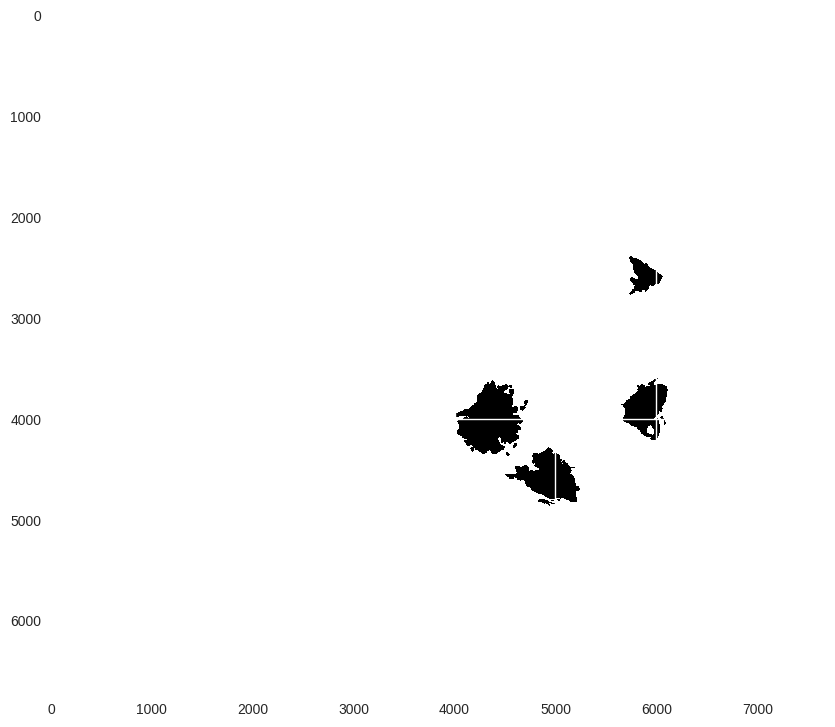

In [19]:
# Example: read the entire mask at the same zoom level
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=3, 
                        width=slide.level_dimensions[3][0], 
                        height=slide.level_dimensions[3][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image)

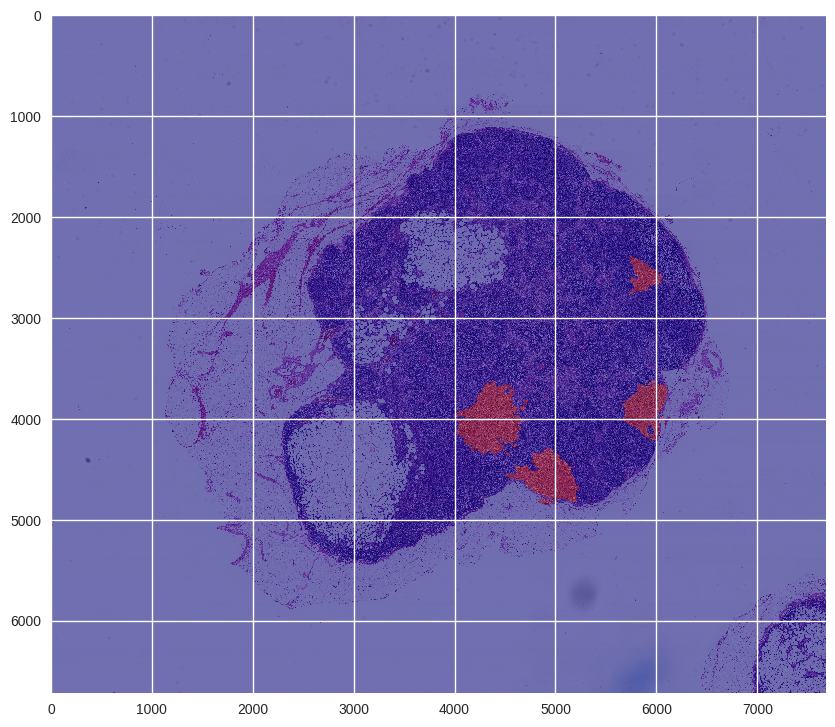

In [20]:
# Overlay them. The idea is that the mask shows the region of the slide that
# contain cancerous cells.

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

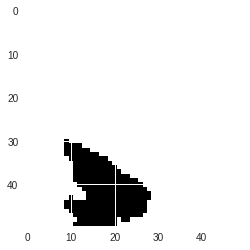

In [21]:
# Example: extract a region from the L7 downsampled image
# Notice we're multiplying the x,y coordinates by the downsample factor.
# This math can be tricky to get right, debug carefully.
# Here, we're "aiming" for the top right blob in the image above.

region = read_slide(tumor_mask, x=350 * 128, y=120 * 128, level=7, width=50, height=50)[:,:,0]
plt.imshow(region)

13344403 tissue_pixels pixels (29.6 percent of the image)


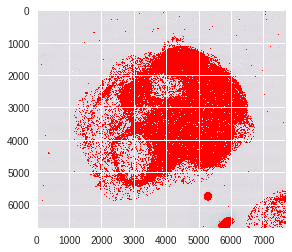

In [22]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])

tissue_pixels = find_tissue_pixels(slide_image)
percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

tissue_regions = apply_mask(slide_image, tissue_pixels)
plt.imshow(tissue_regions)

In [0]:
tissue_image = np.zeros_like(mask_image)
for x, y in tissue_pixels: tissue_image[x][y] = 1

# plt.imshow(tissue_image)

In [0]:
slide_image.shape, mask_image.shape

((6720, 7680, 3), (6720, 7680))

In [0]:
scaled_slide_image = slide_image / 255.0

In [0]:
from sklearn.utils import shuffle

In [0]:
def get_patches(slide_image, mask_image, tissue_image, stride, patch_size, center_size, issue_threshold):
    zeros_X = []
    ones_X = []
    y = []
    tmp = (patch_size-center_size)/2
    patch_square = float(patch_size*patch_size)
#     patch_list, mask_patch_list, tissue_patch_list = [], [], []
    for y in range(0, slide_image.shape[0]-patch_size, stride):
        for x in range(0, slide_image.shape[1]-patch_size, stride):
            mask_patch = mask_image[y+tmp:y+tmp+center_size, x+tmp:x+tmp+center_size]
            if np.sum(mask_patch)>1:
                patch = slide_image[y:y+patch_size, x:x+patch_size]
                ones_X.append(patch)
                ones_X.append(np.rot90(patch, k=1))
                ones_X.append(np.rot90(patch, k=2))
                ones_X.append(np.rot90(patch, k=3))
                fliped_patch = np.flip(patch, axis=0)
                ones_X.append(fliped_patch)
                ones_X.append(np.rot90(fliped_patch, k=1))
                ones_X.append(np.rot90(fliped_patch, k=2))
                ones_X.append(np.rot90(fliped_patch, k=3))
            else:
                ratio = np.sum(tissue_image[y:y+patch_size, x:x+patch_size])/patch_square
                if ratio>=issue_threshold:
                    patch = slide_image[y:y+patch_size, x:x+patch_size]
                    zeros_X.append(patch)
            
#             patch = slide_image[y:y+patch_size, x:x+patch_size]
#             mask_patch = mask_image[y:y+patch_size, x:x+patch_size]
#             tissue_patch = tissue_image[y:y+patch_size, x:x+patch_size]
#             patch_list.append(patch)
#             mask_patch_list.append(mask_patch)
#             tissue_patch_list.append(tissue_patch)
#     return np.asarray(patch_list), np.asarray(mask_patch_list), np.asarray(tissue_patch_list)
    zeros_X, ones_X = np.asarray(zeros_X), np.asarray(ones_X)
    np.random.shuffle(zeros_X)
    train_X = np.concatenate((zeros_X[0:len(ones_X)], ones_X))
    train_y = np.asarray([0]*len(ones_X)+[1]*len(ones_X))
    train_X, train_y = shuffle(train_X, train_y, random_state=0)
    return train_X, train_y

In [0]:
# patch_list, mask_patch_list, tissue_patch_list = get_patches(slide_image, mask_image, tissue_image, 3000, 3000, 1000)
# patch_list.shape

In [0]:
# zeros_X, ones_X = get_patches(scaled_slide_image, mask_image, tissue_image, 80, 150, 100)
# zeros_X.shape, ones_X.shape
# plt.imshow(ones_X[0])


train_X, train_y = get_patches(scaled_slide_image, mask_image, tissue_image, 80, 150, 100, 0.2)

In [0]:
# plt.imshow(ones_X[10])

In [0]:
# plt.imshow(np.rot90(ones_X[10], k=1))

In [0]:
# plt.imshow(np.flip(ones_X[10], axis=0))

In [0]:
# np.random.shuffle(zeros_X)
# train_X = np.concatenate((zeros_X[0:len(ones_X)], ones_X))
# train_y = np.asarray([0]*len(ones_X)+[1]*len(ones_X))
train_X.shape, train_y.shape

((3344, 150, 150, 3), (3344,))

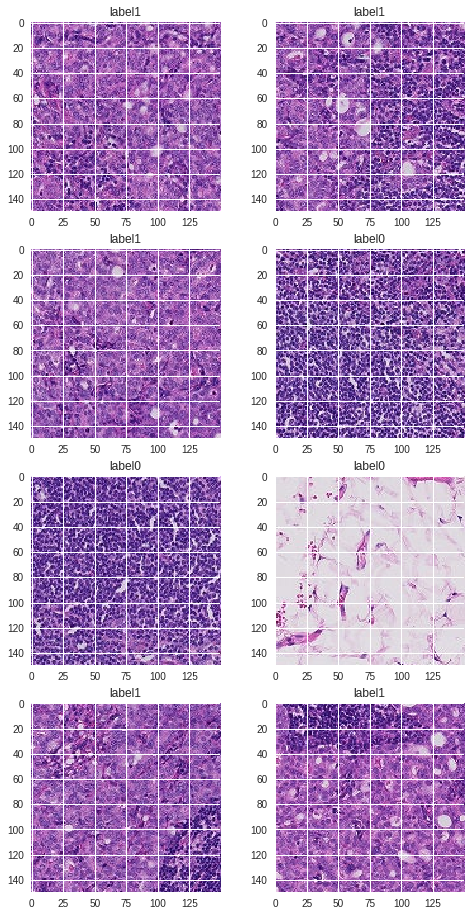

In [0]:
# plt.figure(figsize=(8,8))
# count=1
# for i in np.random.choice(len(train_X),4):
#   plt.subplot(2,2,count)
#   plt.imshow((train_X[i]*255).astype('uint8'))
#   count += 1

plt.figure(figsize=(8, 16))
count = 1
for i in range(8):
    plt.subplot(4,2,count)
    plt.imshow((train_X[i]*255).astype('uint8'))
    plt.title('label'+str(train_y[i]))
    count += 1

In [0]:
# def _parse_function(train_location, level):
#     downsample = int(slide.level_downsamples[level])
#     image = read_slide(slide, x=train_location[0]*downsample, 
#                        y=train_location[1]*downsample, 
#                        level=level, width=299, height=299)
#     image = image / 255.0
        
#     #Use filp and rotation to carry out the data augmentation of training data
# #     image_resized = tf.image.random_flip_left_right(image_resized)
# #     rotate_or_not = random.choice((True, False))
# #     if rotate_or_not:
# #         radians = np.random.uniform(-0.262, 0.262)
# #         image_resized = tf.contrib.image.rotate(image_resized, radians)
        
# #     label = tf.one_hot(filelabellist, depth = 3)

# #     mask_image = read_slide(tumor_mask, x=(train_location[0]+128)*downsample, 
# #                             y=(train_location[1]+128)*downsample, 
# #                             level=level, width=128, height=128)
# #     mask_image = mask_image[:,:,0]
# #     res = 1 if sum(map(sum, mask_image))>0 else 0
    
#     return image


In [0]:
# def get_0_1(level):
#     zeros, ones = [], []
#     downsample = int(slide.level_downsamples[level])
#     for x in range(0, slide.level_dimensions[level][1]-299, 64):
#         for y in range(0, slide.level_dimensions[level][0]-299, 64):
#             mask_image = read_slide(tumor_mask, 
#                                     x=(x+85)*downsample, 
#                                     y=(y+85)*downsample, 
#                                     level=level, width=128, height=128)
#             mask_image = mask_image[:,:,0]
#             res = 1 if sum(map(sum, mask_image))>0 else 0
#             if res:
#                 ones.append((x, y))
#             else:
#                 image = read_slide(slide, x=x*downsample, 
#                        y=y*downsample, 
#                        level=level, width=299, height=299)
#                 tissues = find_tissue_pixels(image)
#                 if len(tissues)/(299.0*299.0)>=0.3:
#                     zeros.append((x, y))
#     return zeros, ones

In [0]:
# zeros, ones = get_0_1(3)
# len(zeros), len(ones)

In [0]:
# def create_dataset(size, level):
#     X, y, locations = [], [], []
#     tmp = 0
#     while tmp<size:
#         rand = random.randint(0,1)
#         y.append(rand)
#         if rand:
#             locations.append(random.sample(ones, 1)[0])
#         else:
#             locations.append(random.sample(zeros, 1)[0])
#         tmp += 1
            
#     for loc in locations:
#         data = _parse_function(loc, level)
#         X.append(data)
#     return np.asarray(X), np.asarray(y)

In [0]:
# train_X, train_y = create_dataset(1000, level=3)

In [0]:
# train_X[6]

In [0]:
# for i in range(10):
#     im = (train_X[i]*255).astype('uint8')
#     plt.imshow(im)
#     plt.show()

In [0]:
# train_X.shape, train_y.shape[0], sum(train_y).astype('float')/train_y.shape[0]

In [0]:
import tensorflow as tf
from keras import models
from keras import layers
from keras import applications
from keras.layers import Dropout, Flatten, Dense
base_model = applications.VGG16(include_top=False, 
                           input_shape = (150, 150, 3))

x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dense(512, activation="relu")(x)
x = Dense(1, activation="sigmoid")(x)
    
model = models.Model(input = base_model.input, output = x)
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  from ipykernel import kernelapp as app


In [0]:
optimizer = tf.train.MomentumOptimizer(0.001, momentum=0.9, use_nesterov=True)
model.compile(optimizer=optimizer, loss='binary_crossentropy', 
              metrics=['accuracy'])

history = model.fit(train_X, train_y, epochs=15, batch_size=32, 
                    validation_split=0.3, shuffle = True)

Train on 2340 samples, validate on 1004 samples
Epoch 1/15
2340/2340 [==============================] - 50s 21ms/step - loss: 0.4146 - acc: 0.7893 - val_loss: 1.4903 - val_acc: 0.4910
Epoch 2/15
2340/2340 [==============================] - 40s 17ms/step - loss: 0.2859 - acc: 0.8739 - val_loss: 0.1786 - val_acc: 0.9263
Epoch 3/15
2340/2340 [==============================] - 40s 17ms/step - loss: 0.1957 - acc: 0.9188 - val_loss: 1.7294 - val_acc: 0.5329
Epoch 4/15
2340/2340 [==============================] - 40s 17ms/step - loss: 0.2661 - acc: 0.8872 - val_loss: 0.1931 - val_acc: 0.9173
Epoch 5/15
2340/2340 [==============================] - 40s 17ms/step - loss: 0.1331 - acc: 0.9513 - val_loss: 0.0894 - val_acc: 0.9671
Epoch 6/15
2340/2340 [==============================] - 40s 17ms/step - loss: 0.0665 - acc: 0.9735 - val_loss: 0.0676 - val_acc: 0.9751
Epoch 7/15
2340/2340 [==============================] - 40s 17ms/step - loss: 0.0536 - acc: 0.9812 - val_loss: 0.0338 - val_acc: 0.9890


KeyboardInterrupt: ignored

In [0]:
model.save('my_model_v3.h5')

/usr/local/lib/python2.7/dist-packages/keras/engine/saving.py:118: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


In [0]:
def generate_test_mask(test_slide, level, patch_size, center_size):
    downsample = int(test_slide.level_downsamples[level])
    result_image = np.zeros(shape=(test_slide.level_dimensions[level][1], 
                                   test_slide.level_dimensions[level][0]))
    tmp = (patch_size-center_size)/2
    for x in range(0, test_slide.level_dimensions[level][0]-patch_size, center_size):
        for y in range(0, test_slide.level_dimensions[level][1]-patch_size, center_size):
            image = read_slide(test_slide, 
                               x=x*downsample, 
                               y=y*downsample, 
                               level=level, width=patch_size, height=patch_size)
            image = image / 255.0
            prediction = model.predict(np.expand_dims(image, 0))
            
            for m in range(x+tmp, x+tmp+center_size):
                for n in range(y+tmp, y+tmp+center_size):
                    result_image[n][m] = prediction

    return result_image

In [0]:
test_mask_image_pred = generate_test_mask(slide, 3, 150, 100)
# plt.figure(figsize=(10,10), dpi=100)
# plt.imshow(test_slide_image)
# plt.imshow(test_mask_image, cmap='jet', alpha=0.5)
# plt.imshow(test_mask_image_pred, cmap='jet', alpha=0.5) # Red regions contains cancer.

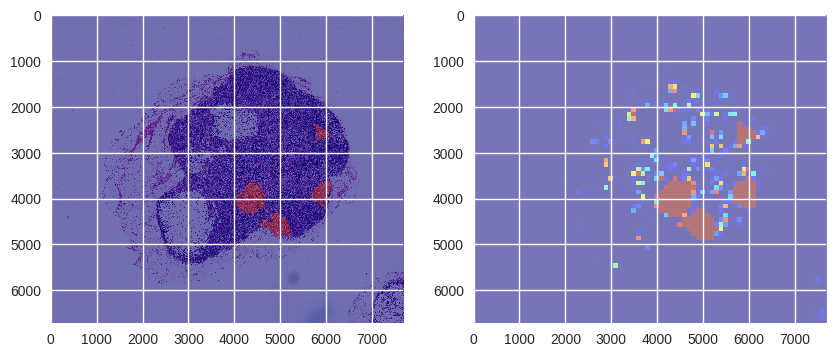

In [0]:
plt.figure(figsize=(10,8), dpi=100)
plt.subplot(1, 2, 1)
plt.imshow(slide_image)
# test_mask_image_pred.shape, test_slide_image.shape
plt.imshow(mask_image, cmap='jet', alpha=0.5)
plt.subplot(1, 2, 2)
plt.imshow(test_mask_image_pred, cmap='jet', alpha=0.5) # Red regions contains cancer.

In [0]:
import sklearn
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [0]:
roc_auc_score(mask_image.reshape(-1), test_mask_image_pred.reshape(-1))

0.9983034004612835

In [0]:
import sys
def get_memory_used(l):
    d = {}
    for i in l:
        d[i] = sys.getsizeof(eval(i))/1024/1024
    return d

In [0]:
d = get_memory_used(dir())
d

{'Dense': 0,
 'Dropout': 0,
 'Flatten': 0,
 'Image': 0,
 'In': 0,
 'Out': 0,
 '_': 0,
 '_13': 0,
 '_22': 0,
 '_35': 0,
 '_38': 0,
 '_7': 0,
 '__': 0,
 '___': 0,
 '__builtin__': 0,
 '__builtins__': 0,
 '__doc__': 0,
 '__name__': 0,
 '__package__': 0,
 '_dh': 0,
 '_exit_code': 0,
 '_i': 0,
 '_i1': 0,
 '_i10': 0,
 '_i11': 0,
 '_i12': 0,
 '_i13': 0,
 '_i14': 0,
 '_i15': 0,
 '_i16': 0,
 '_i17': 0,
 '_i18': 0,
 '_i19': 0,
 '_i2': 0,
 '_i20': 0,
 '_i21': 0,
 '_i22': 0,
 '_i23': 0,
 '_i24': 0,
 '_i25': 0,
 '_i26': 0,
 '_i27': 0,
 '_i28': 0,
 '_i29': 0,
 '_i3': 0,
 '_i30': 0,
 '_i31': 0,
 '_i32': 0,
 '_i33': 0,
 '_i34': 0,
 '_i35': 0,
 '_i36': 0,
 '_i37': 0,
 '_i38': 0,
 '_i39': 0,
 '_i4': 0,
 '_i40': 0,
 '_i5': 0,
 '_i6': 0,
 '_i7': 0,
 '_i8': 0,
 '_i9': 0,
 '_ih': 0,
 '_ii': 0,
 '_iii': 0,
 '_oh': 0,
 '_sh': 0,
 'applications': 0,
 'apply_mask': 0,
 'base_model': 0,
 'count': 0,
 'exit': 0,
 'find_tissue_pixels': 0,
 'generate_test_mask': 0,
 'get_ipython': 0,
 'get_memory_used': 0,
 'get_pat

In [0]:
import gc
del tissue_image, tissue_pixels, train_X, train_y, scaled_slide_image, test_mask_image_pred, slide, slide_image, mask_image, tumor_mask
gc.collect()

0

In [0]:
# Download an example slide and tumor mask
# Note: these are hosted on Google Cloud Storage.
# The remainder are in a Google Drive folder, linked above.

test_slide_path = 'tumor_110.tif'
test_tumor_mask_path = 'tumor_110_mask.tif'

# test_slide_url = 'https://storage.googleapis.com/applied-dl/%s' % test_slide_path
# test_mask_url = 'https://storage.googleapis.com/applied-dl/%s' % test_tumor_mask_path


# # Download the whole slide image
# if not os.path.exists(test_slide_path):
#   !curl -O $test_slide_url

# # Download the tumor mask
# if not os.path.exists(test_tumor_mask_path):
#   !curl -O $test_mask_url

In [0]:
test_slide = open_slide(test_slide_path)
# print ("Read WSI from %s with width: %d, height: %d" % (test_slide_path, 
#                                                         test_slide.level_dimensions[0][0], 
#                                                         test_slide.level_dimensions[0][1]))

test_tumor_mask = open_slide(test_tumor_mask_path)
# print ("Read tumor mask from %s" % (test_tumor_mask_path))

# print("Slide includes %d levels", len(test_slide.level_dimensions))
# for i in range(len(test_slide.level_dimensions)):
#     print("Level %d, dimensions: %s downsample factor %d" % (i, 
#                                                              test_slide.level_dimensions[i], 
#                                                              test_slide.level_downsamples[i]))
#     assert test_tumor_mask.level_dimensions[i][0] == test_slide.level_dimensions[i][0]
#     assert test_tumor_mask.level_dimensions[i][1] == test_slide.level_dimensions[i][1]

# # Verify downsampling works as expected
# width, height = test_slide.level_dimensions[7]
# assert width * test_slide.level_downsamples[7] == test_slide.level_dimensions[0][0]
# assert height * test_slide.level_downsamples[7] == test_slide.level_dimensions[0][1]

In [0]:
test_slide_image = read_slide(test_slide, 
                         x=0, 
                         y=0, 
                         level=3, 
                         width=test_slide.level_dimensions[3][0], 
                         height=test_slide.level_dimensions[3][1])

# plt.figure(figsize=(10,10), dpi=100)
# plt.imshow(test_slide_image)

In [0]:
# Example: read the entire mask at the same zoom level
test_mask_image = read_slide(test_tumor_mask, 
                            x=0, 
                            y=0, 
                            level=3, 
                            width=test_slide.level_dimensions[3][0], 
                            height=test_slide.level_dimensions[3][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
test_mask_image = test_mask_image[:,:,0]

# plt.figure(figsize=(10,10), dpi=100)
# plt.imshow(test_mask_image)

In [0]:
# plt.figure(figsize=(10,10), dpi=100)
# plt.imshow(test_slide_image)
# plt.imshow(test_mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

In [0]:
test_mask_image_pred = generate_test_mask(test_slide, 3, 150, 100)

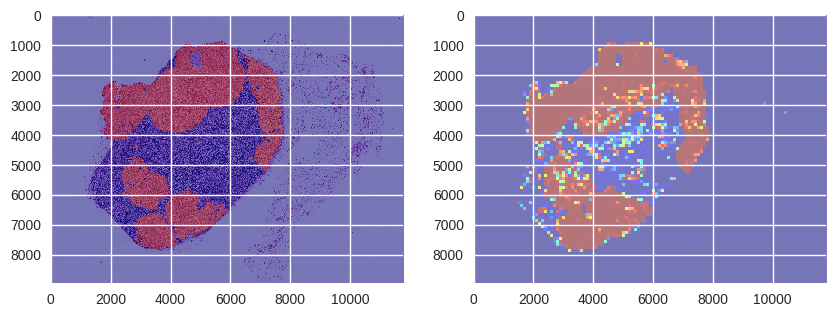

In [0]:
plt.figure(figsize=(10,8), dpi=100)
plt.subplot(1, 2, 1)
plt.imshow(test_slide_image)
# test_mask_image_pred.shape, test_slide_image.shape
plt.imshow(test_mask_image, cmap='jet', alpha=0.5)
plt.subplot(1, 2, 2)
plt.imshow(test_mask_image_pred, cmap='jet', alpha=0.5) # Red regions contains cancer.

In [0]:
d = get_memory_used(dir())
d

{'Dense': 0,
 'Dropout': 0,
 'Flatten': 0,
 'Image': 0,
 'In': 0,
 'Out': 0,
 '_': 0,
 '_13': 0,
 '_22': 0,
 '_35': 0,
 '_38': 0,
 '_40': 0,
 '_41': 0,
 '_48': 0,
 '_51': 0,
 '_7': 0,
 '__': 0,
 '___': 0,
 '__builtin__': 0,
 '__builtins__': 0,
 '__doc__': 0,
 '__name__': 0,
 '__package__': 0,
 '_dh': 0,
 '_exit_code': 0,
 '_i': 0,
 '_i1': 0,
 '_i10': 0,
 '_i11': 0,
 '_i12': 0,
 '_i13': 0,
 '_i14': 0,
 '_i15': 0,
 '_i16': 0,
 '_i17': 0,
 '_i18': 0,
 '_i19': 0,
 '_i2': 0,
 '_i20': 0,
 '_i21': 0,
 '_i22': 0,
 '_i23': 0,
 '_i24': 0,
 '_i25': 0,
 '_i26': 0,
 '_i27': 0,
 '_i28': 0,
 '_i29': 0,
 '_i3': 0,
 '_i30': 0,
 '_i31': 0,
 '_i32': 0,
 '_i33': 0,
 '_i34': 0,
 '_i35': 0,
 '_i36': 0,
 '_i37': 0,
 '_i38': 0,
 '_i39': 0,
 '_i4': 0,
 '_i40': 0,
 '_i41': 0,
 '_i42': 0,
 '_i43': 0,
 '_i44': 0,
 '_i45': 0,
 '_i46': 0,
 '_i47': 0,
 '_i48': 0,
 '_i49': 0,
 '_i5': 0,
 '_i50': 0,
 '_i51': 0,
 '_i52': 0,
 '_i53': 0,
 '_i6': 0,
 '_i7': 0,
 '_i8': 0,
 '_i9': 0,
 '_ih': 0,
 '_ii': 0,
 '_iii': 0,
 '_oh'

In [0]:
import gc
del test_tumor_mask, test_slide, test_slide_image
gc.collect()

3

In [0]:
np.save('test_mask_pred_tumor_110_image', test_mask_image_pred)

In [0]:
np.save('test_mask_tumor_110_image', test_mask_image)

In [0]:
test_mask_image = test_mask_image.reshape(-1)
test_mask_image_pred = test_mask_image_pred.reshape(-1)

In [0]:
roc_auc_score(test_mask_image, test_mask_image_pred)

0.97901706259915

In [0]:
# in order to save the memory, use for loop to get the label in space

In [0]:
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

In [0]:
test_mask_image_pred = np.load('test_mask_pred_tumor_110_image.npy')
test_mask_image = np.load('test_mask_tumor_110_image.npy')

In [0]:
test_mask_image = test_mask_image.reshape(-1)
test_mask_image_pred = test_mask_image_pred.reshape(-1)

In [0]:
fpr, tpr, thresholds = roc_curve(test_mask_image, test_mask_image_pred, pos_label=1)

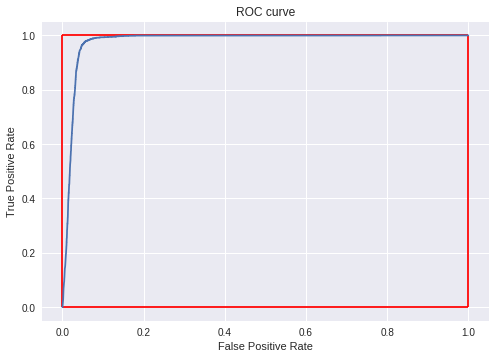

In [10]:
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(fpr, tpr)
plt.vlines(0, ymin=0, ymax=1, color='red')
plt.vlines(1, ymin=0, ymax=1, color='red')
plt.hlines(0, xmin=0, xmax=1, color='red')
plt.hlines(1, xmin=0, xmax=1, color='red')
plt.show()

In [0]:
threshold = 0.7

In [0]:
for i in range(len(test_mask_image)):
    test_mask_image_pred[i] = 1 if test_mask_image_pred[i]>=threshold else 0

In [13]:
type(test_mask_image[0]), type(test_mask_image_pred[0])

(numpy.uint8, numpy.float64)

In [0]:
test_mask_image_pred = test_mask_image_pred.astype(int)

In [0]:
confusion_mat = confusion_matrix(test_mask_image, test_mask_image_pred)

In [16]:
confusion_mat

array([[85251678,  3812081],
       [  901282, 15547919]])

In [17]:
recall = float(confusion_mat[0][0]) / np.sum(confusion_mat[0])
precision = float(confusion_mat[0][0]) / (confusion_mat[0][0] + confusion_mat[1][0])
F1_score = 2* precision * recall / (precision + recall)
precision, recall, F1_score

(0.989538583468287, 0.9571982920684944, 0.9730998101842097)